# 0.0 Imports

In [1]:
import pandas as pd
import numpy  as np
import pickle

import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model    as lm

# 0.1 Loading Dataset

In [2]:
df_raw = pd.read_csv( '../data/raw/train.csv')

In [3]:
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


# 1.0 Data description

In [4]:
# Creating a copy for every start of seccion
df1 = df_raw.copy()

In [5]:
# Renaming Columns
cols_new = df1.columns.to_list()
cols_new = [word.lower() for word in cols_new]
df1.columns = cols_new


# 1.1 Data Dimensions

In [6]:
print ( ' The number of rows of the Dataset is: {} '.format (df1.shape[0]))
print ( ' The number of cols of the Dataset is: {} '.format (df1.shape[1]))

 The number of rows of the Dataset is: 381109 
 The number of cols of the Dataset is: 12 


# 1.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

# 1.3 Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

# 1.4 Descriptive Analysis

In [9]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [10]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
ct2 = pd.DataFrame( num_attributes.apply( np.median ) )

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ) 
d2 = pd.DataFrame( num_attributes.apply( min ) ) 
d3 = pd.DataFrame( num_attributes.apply( max ) )
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ) 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ) 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [11]:
# Creating a copy for every start of seccion
df2 = df1.copy()

In [12]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x :  'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x : 1 if x == 'Yes' else 0)

In [13]:
df2

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,between_1_2_year,0,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,below_1_year,0,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,below_1_year,0,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,over_2_years,1,44617.0,124.0,74,0


# 3.0 Data Filtering

In [14]:
# Creating a copy for every start of seccion
df3 = df2.copy()

# 4.0 Exploration Data Analysis

In [15]:
# Creating a copy for every start of seccion
df4 = df3.copy()

# 4.1 Univariate Analysis

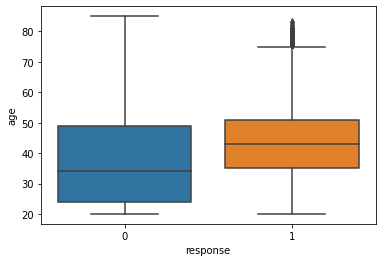

In [16]:
# age
# as medianas são rasoavelmente diferentes, o que indica que essa variável pode impactar o fenômeno . Nas pessoas que não tem interesse, 
# tem uma concentração muito grande em pessoas novas, e depois decai, se assemelhando a uma distribuição de Poisson. Já nas que tem interesse,
# a distribuição se parece com uma normal onde pessoas de meia idade são as que tem mais interesse

sns.boxplot(x='response',y= 'age',data= df4);

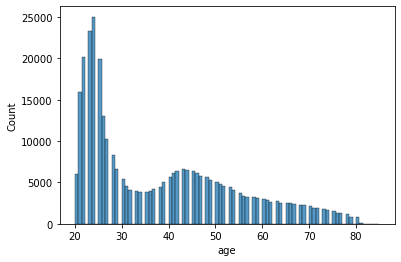

In [17]:
sns.histplot(df4.loc[df4['response']==0 , 'age']);

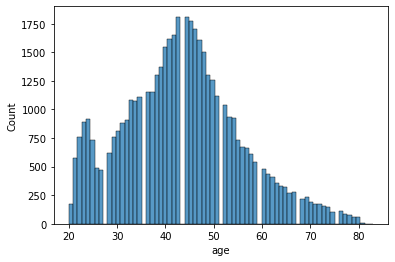

In [18]:
sns.histplot(df4.loc[df4['response']==1 , 'age']);

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

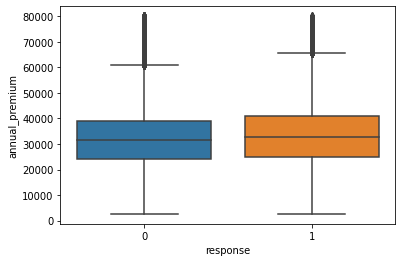

In [19]:
# annual_premium

# Não há muita diferença entre as medianas e as distribuições são muito parecidas, por isso, essa variável sozinha não diz muito
# sobre o fenômeno

aux = df4 [ df4[ 'annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = aux)

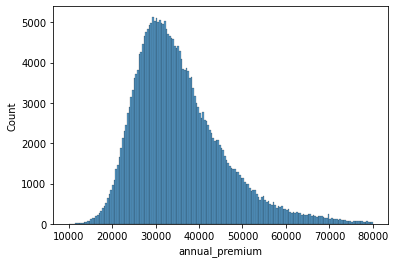

In [20]:
aux = aux = df4 [ (df4[ 'annual_premium'] > 10000) & (df4[ 'annual_premium'] < 80000)]
aux00 = aux.loc[aux['response']==0 , 'annual_premium']
sns.histplot(aux00);

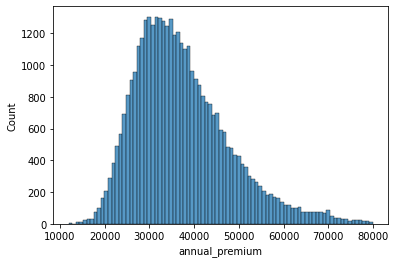

In [21]:
aux = aux = df4 [ (df4[ 'annual_premium'] > 10000) & (df4[ 'annual_premium'] < 80000)]
aux00 = aux.loc[aux['response']==1 , 'annual_premium']
sns.histplot(aux00);

In [22]:
# driving_license
# é até contra intuitivo pessoas que não tem carteira de motorista que tem interesse em seguro de carro, a não ser que seja
# para os familiares ou amigos

aux = df4[['driving_license', 'response', 'id']].groupby(['driving_license', 'response']).count().reset_index()
aux = aux.rename(columns={'id':'count'})
aux.head()



,driving_license,response,count
0,0,0,771
1,0,1,41
2,1,0,333628
3,1,1,46669


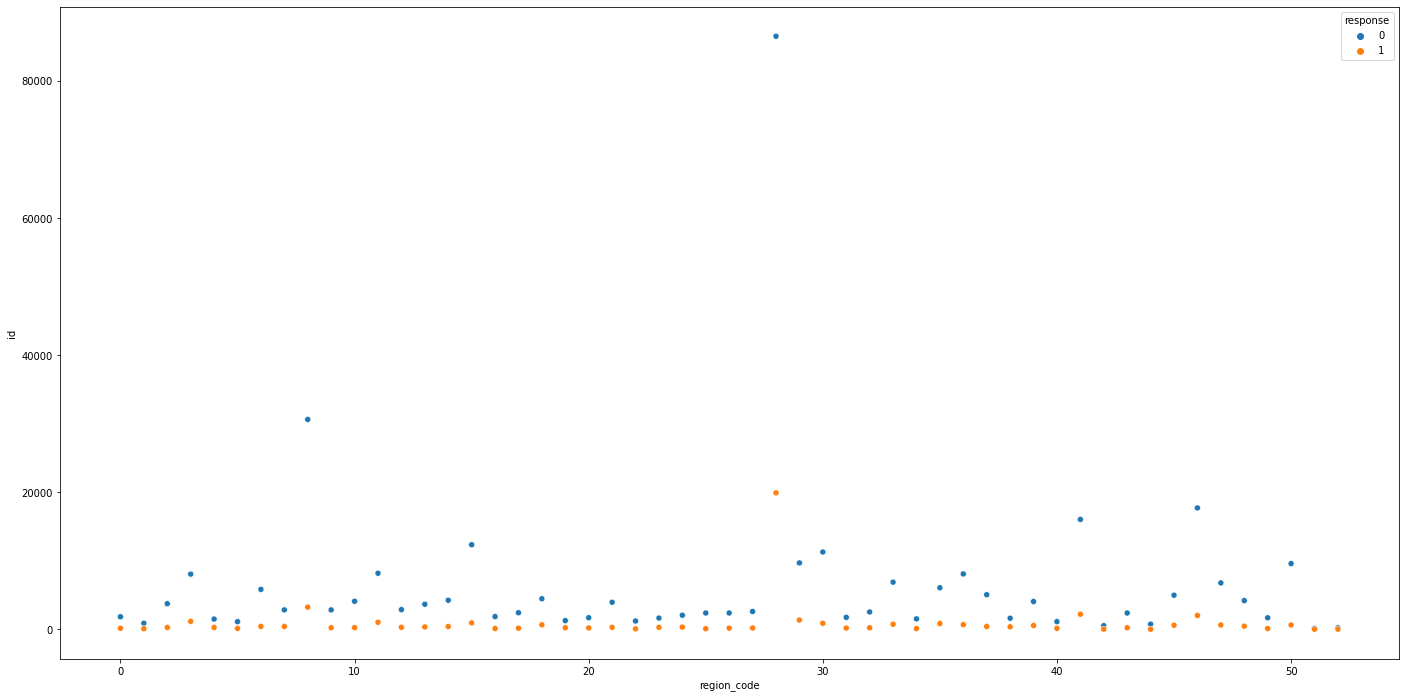

In [23]:
# region_code
# é inconclusivo porque para a maioria das region_codes ela não é uma variável discriminatória, com exceção por exemplo da region_code 28
# na maioria, response 1 e 0 estão com a contagem muito parecida
plt.figure (figsize = (24,12))
aux = df4[['region_code', 'response', 'id']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x= 'region_code', y= 'id', hue = 'response', data= aux);

In [24]:
# previously_insured
# pode ser uma variável indicativa, há uma discrepância grande entre classes
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x : x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [25]:
# vehicle_age
# pode ser uma variável com impacto significante na variável resposta, pois quanto mais velho o carro, mais as pessoas tem interesse
# em contratar o seguro
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x : x / x.sum(), axis = 1)

response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_year,0.826245,0.173755
over_2_years,0.706254,0.293746


In [26]:
# vehicle_damage


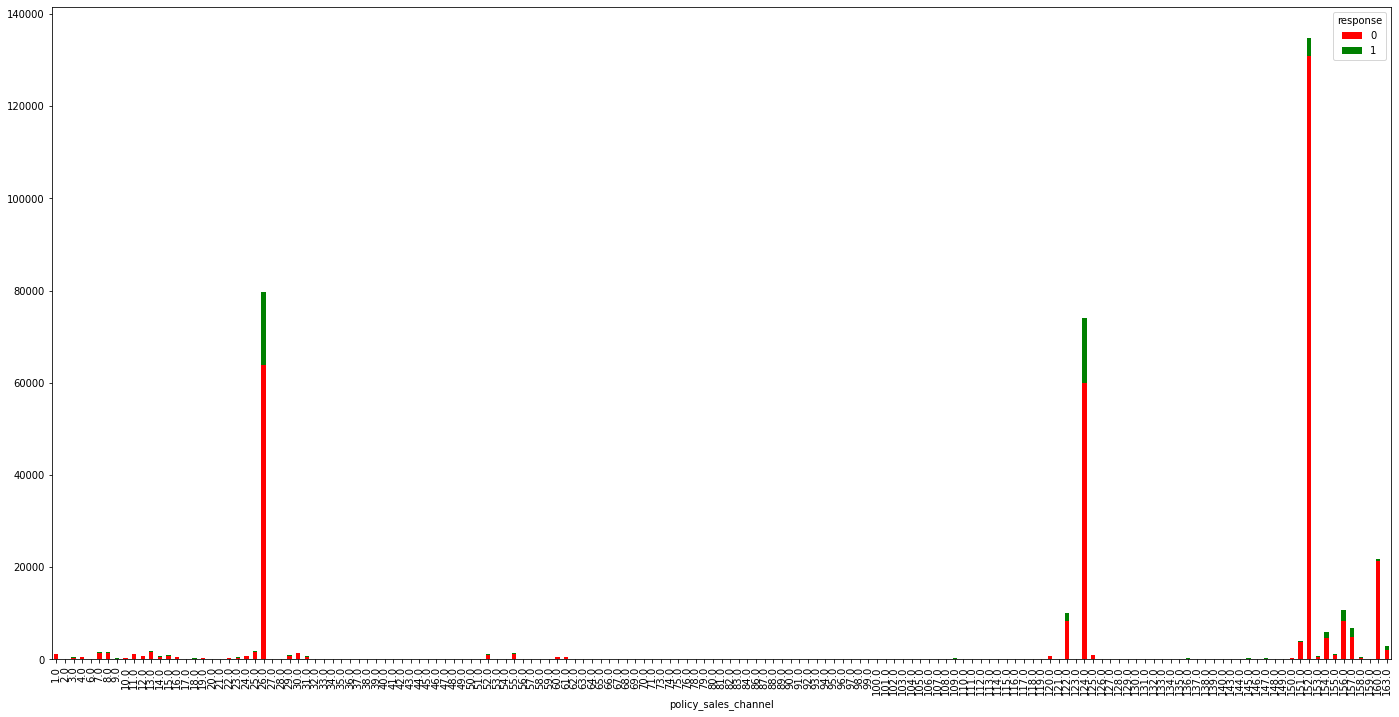

In [27]:
plt.rcParams['figure.figsize'] = [24, 12]
aux = pd.crosstab(df4['policy_sales_channel'], df4['response'])
aux.plot(kind='bar', stacked=True, color=['red',  'green'])
plt.xticks( rotation = 90)
plt.show()
plt.rcParams['figure.figsize'] = [6,4 ]

In [28]:
# policy_sales_channel

# pode ser uma variável discriminatória, pois em certos canais, as pessoas responderam em sua totalidade que não tinham interesse no 
# seguro de carros
from IPython.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 10):
    aux = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x : x/ x.sum(), axis =1).sort_values(0, ascending=False)
    display (aux)

response,0,1
policy_sales_channel,,
74.0,1.000000,0.000000
75.0,1.000000,0.000000
96.0,1.000000,0.000000
95.0,1.000000,0.000000
84.0,1.000000,0.000000
83.0,1.000000,0.000000
82.0,1.000000,0.000000
79.0,1.000000,0.000000
76.0,1.000000,0.000000


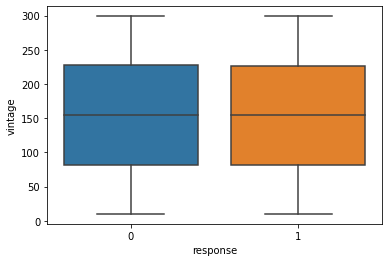

In [29]:
# vintage
# Pela distribuição da variável percebemos que a base é homegenea em relação ao número de dias que as pessoas estão associadas
# a compania e pelo boxplot percebemos que não há distinção entre as pessoas que tem interesse e não tem interesse no seguro
# por esse aspecto
sns.boxplot(x = 'response', y = 'vintage', data = df4);

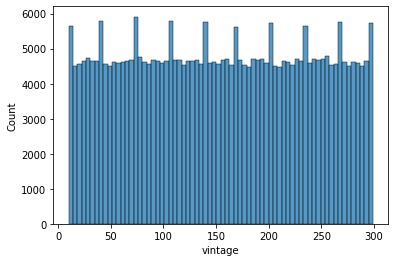

In [30]:
aux00 = df4.loc[df4['response']==0 , 'vintage']
sns.histplot(aux00);

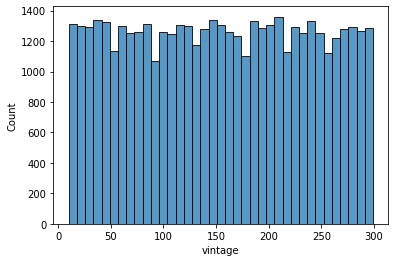

In [31]:
aux00 = df4.loc[df4['response']==1 , 'vintage']
sns.histplot(aux00);

# 5.0 Data Preparation

In [42]:
df5 = df4.copy()

In [43]:
x = df5.drop('response' , axis = 1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(x , y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis = 1)

# Standardization

In [44]:
ss = pp.StandardScaler()

# annual premium
df5['annual_premium'] = ss.fit_transform (df5[['annual_premium']].values)
pickle.dump( ss, open( '../../../../health_insurance_app/features/annual_premium_scaler.pkl', 'wb' ) )

# Rescaling

In [45]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age

df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump( mms_age, open( '../../../../health_insurance_app/features/age_scaler.pkl', 'wb' ) )

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump( mms_vintage, open( '../../../../health_insurance_app/features/vintage_scaler.pkl', 'wb' ) )


# Encoder

In [46]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../../../../health_insurance_app/features/target_encode_gender_scaler.pkl', 'wb' ) )


# region code - Target encoder
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '../../../../health_insurance_app/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle age - One hot encoding
df5 = pd.get_dummies(df5, prefix = 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../../../../health_insurance_app/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )


# 5.4 Validation Preparation

In [47]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0 Feature Selection

In [37]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit (x_train_n , y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.272686
0                annual_premium    0.243990
0                           age    0.167659
0                   region_code    0.103128
0                vehicle_damage    0.067884
0          policy_sales_channel    0.060119
0            previously_insured    0.056480
0      vehicle_age_below_1_year    0.014078
0  vehicle_age_between_1_2_year    0.006415
0                        gender    0.004681
0      vehicle_age_over_2_years    0.002388
0               driving_license    0.000492


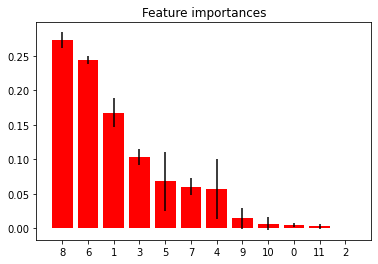

In [38]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning

In [48]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[cols_selected]
x_val = x_validation [cols_selected]
y_val = y_validation.copy()

# 7.1 KNN

In [49]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training

knn_model.fit (x_train , y_train)

# model prediction 

yhat_knn = knn_model.predict_proba(x_val)

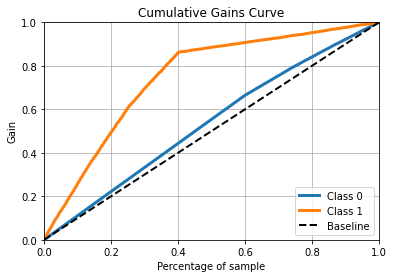

In [50]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

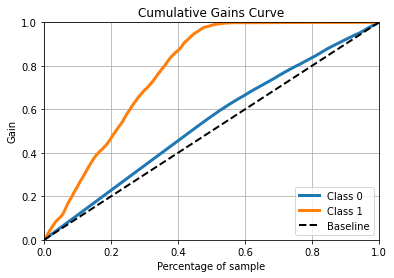

In [51]:
# model definition

lr_model = lm.LogisticRegression(random_state = 42)

# model training

lr_model.fit (x_train , y_train)

# model prediction 

yhat_lr = lr_model.predict_proba(x_val)

 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

# 7.2 Extra Trees

In [52]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=50, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train, y_train )

# model predict
yhat_et = et.predict_proba( x_val )

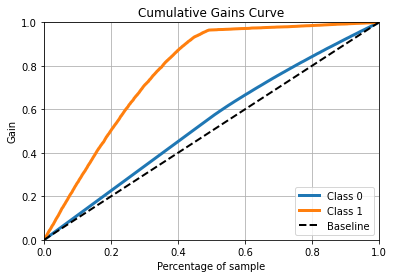

In [53]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

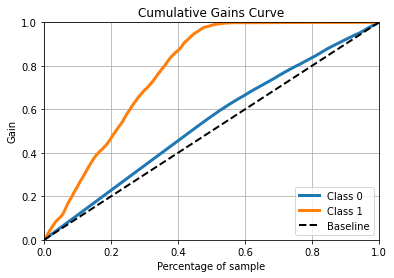

In [54]:
# model definition

lr_model = lm.LogisticRegression(random_state = 42)

# model training

lr_model.fit (x_train , y_train)

# model prediction 

yhat_lr = lr_model.predict_proba(x_val)

 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

# 8.0 Model Performance

In [55]:
def precision_at_k (data, k =2000):
    #reset index
    data = data.reset_index(drop = True)
    
    # Create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

In [56]:
def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


In [57]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

#propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending = False)

# compute precision at k

precision_at_50 = precision_at_k(df8, k=2000)
print('Recall at K: {}'.format(precision_at_50))

# compute recall at k

recall_at_50 = recall_at_k(df8, k = 2000)
print ('Recall at K: {}' .format(recall_at_50))

Recall at K: 0.3423288355822089
Recall at K: 0.073293387545474


In [1]:
df8.head(50)

NameError: name 'df8' is not defined

# 9.0 Deploy to Production

In [58]:
# Save trained model

pickle.dump( lr_model, open( '../../../../health_insurance_app/models/model_health_insurance.pkl', 'wb' ) )

In [1]:
import requests

In [55]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [61]:
df_test = df_raw.sample(50)
df_test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
273943,273944,Female,24,1,8.0,1,< 1 Year,No,37481.0,152.0,225,0
89841,89842,Female,25,1,47.0,0,< 1 Year,No,32370.0,152.0,285,0
163300,163301,Female,41,1,33.0,1,1-2 Year,No,29114.0,152.0,95,0
174647,174648,Male,41,1,26.0,0,1-2 Year,Yes,35231.0,120.0,129,0
198922,198923,Male,45,1,28.0,1,1-2 Year,No,52656.0,124.0,288,0
175235,175236,Female,77,1,28.0,0,1-2 Year,Yes,71542.0,55.0,101,0
41855,41856,Male,29,1,36.0,1,< 1 Year,No,2630.0,152.0,10,0
18043,18044,Female,26,1,21.0,1,< 1 Year,No,22526.0,152.0,217,0
226023,226024,Female,41,1,28.0,0,> 2 Years,Yes,36739.0,26.0,33,0
243897,243898,Male,65,1,28.0,0,> 2 Years,Yes,51161.0,26.0,81,0


In [62]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [63]:
data

'[{"id": 273944, "Gender": "Female", "Age": 24, "Driving_License": 1, "Region_Code": 8.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 37481.0, "Policy_Sales_Channel": 152.0, "Vintage": 225, "Response": 0}, {"id": 89842, "Gender": "Female", "Age": 25, "Driving_License": 1, "Region_Code": 47.0, "Previously_Insured": 0, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 32370.0, "Policy_Sales_Channel": 152.0, "Vintage": 285, "Response": 0}, {"id": 163301, "Gender": "Female", "Age": 41, "Driving_License": 1, "Region_Code": 33.0, "Previously_Insured": 1, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "No", "Annual_Premium": 29114.0, "Policy_Sales_Channel": 152.0, "Vintage": 95, "Response": 0}, {"id": 174648, "Gender": "Male", "Age": 41, "Driving_License": 1, "Region_Code": 26.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 35231.0, "Policy_Sales_Channel": 120.0, "Vintage": 129

In [64]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-prediction-r.herokuapp.com/healthinsurance/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [68]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prediction', ascending=False ).head(50)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction
0,273944,0.100974,0.061538,1,0.091710,1,below_1_year,0,37481.0,152.0,0.743945,0,1.000000
24,220869,0.138872,0.061538,1,0.090206,0,below_1_year,0,54791.0,152.0,0.989619,0,1.000000
26,310580,0.138872,0.076923,1,0.188356,1,below_1_year,0,39055.0,152.0,0.640138,0,1.000000
27,139933,0.100974,0.046154,1,0.116441,0,below_1_year,1,41941.0,152.0,0.221453,0,1.000000
30,210079,0.100974,0.369231,1,0.188356,0,between_1_2_year,1,36537.0,124.0,0.249135,0,1.000000
31,250168,0.100974,0.092308,1,0.067753,0,below_1_year,1,31493.0,152.0,0.809689,0,1.000000
32,277002,0.138872,0.507692,1,0.091710,0,between_1_2_year,1,47932.0,26.0,0.726644,0,1.000000
33,24224,0.100974,0.061538,1,0.091710,1,below_1_year,0,30480.0,152.0,0.159170,0,1.000000
34,344005,0.100974,0.292308,1,0.091710,1,between_1_2_year,0,34966.0,15.0,0.598616,0,1.000000
35,257299,0.138872,0.600000,1,0.091710,0,between_1_2_year,1,34751.0,124.0,0.605536,0,1.000000
